✅ Libraries loaded & seeds set.
✅ Dataset loaded: 11140 rows.
✅ Preprocessing done. Samples: 11140 | Classes: [2777 1061 1813  633  290  830 2090   65 1462  119]
Using device: mps
✅ TensorFlow will use CPU only

📊 Final Splits:
→ Train (85%): 9469 | Test (15%): 1671
→ Train classes: [2360  902 1541  538  247  705 1777   55 1243  101]
→ Test classes:  [417 159 272  95  43 125 313  10 219  18]

🔍 Grid Search + 3-Fold CV on TRAIN (85%)...
  → Trying: lr=0.001, bs=32, ep=6, do=0.2, gru=32
    → CV Acc: 0.6086 ± 0.0041
  → Trying: lr=0.001, bs=32, ep=6, do=0.2, gru=64
    → CV Acc: 0.6156 ± 0.0057
  → Trying: lr=0.001, bs=32, ep=6, do=0.5, gru=32
    → CV Acc: 0.6098 ± 0.0142
  → Trying: lr=0.001, bs=32, ep=6, do=0.5, gru=64
    → CV Acc: 0.6060 ± 0.0110
  → Trying: lr=0.001, bs=32, ep=10, do=0.2, gru=32
    → CV Acc: 0.5919 ± 0.0088
  → Trying: lr=0.001, bs=32, ep=10, do=0.2, gru=64
    → CV Acc: 0.6019 ± 0.0154
  → Trying: lr=0.001, bs=32, ep=10, do=0.5, gru=32
    → CV Acc: 0.5947 ± 0.01

✅ Final model & tokenizer saved.

🟩 FINAL TEST ACCURACY (Held-Out, Natural Distribution): 0.6469

=== FINAL CLASSIFICATION REPORT (TEST SET) ===
                precision    recall  f1-score   support

self direction     0.7146    0.8345    0.7699       417
   stimulation     0.7537    0.6352    0.6894       159
      hedonism     0.6433    0.7096    0.6748       272
   achievement     0.4660    0.5053    0.4848        95
         power     0.7500    0.8372    0.7912        43
      security     0.6134    0.5840    0.5984       125
    conformity     0.5928    0.4185    0.4906       313
     tradition     0.8889    0.8000    0.8421        10
   benevolence     0.5690    0.6027    0.5854       219
  universalism     0.6111    0.6111    0.6111        18

      accuracy                         0.6469      1671
     macro avg     0.6603    0.6538    0.6538      1671
  weighted avg     0.6439    0.6469    0.6405      1671



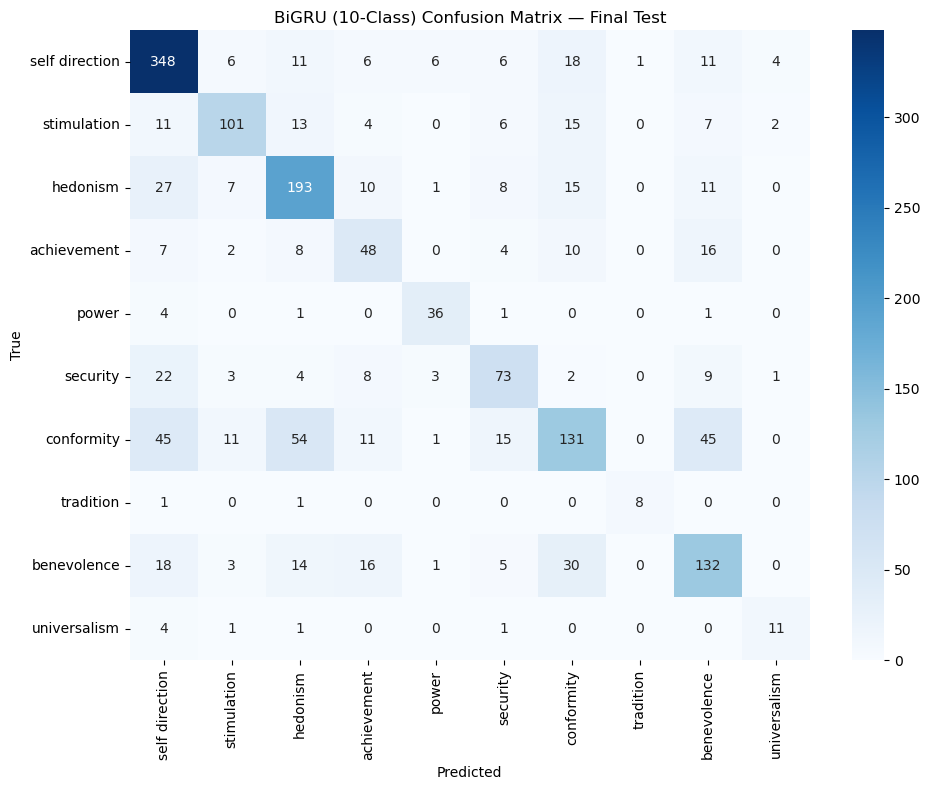

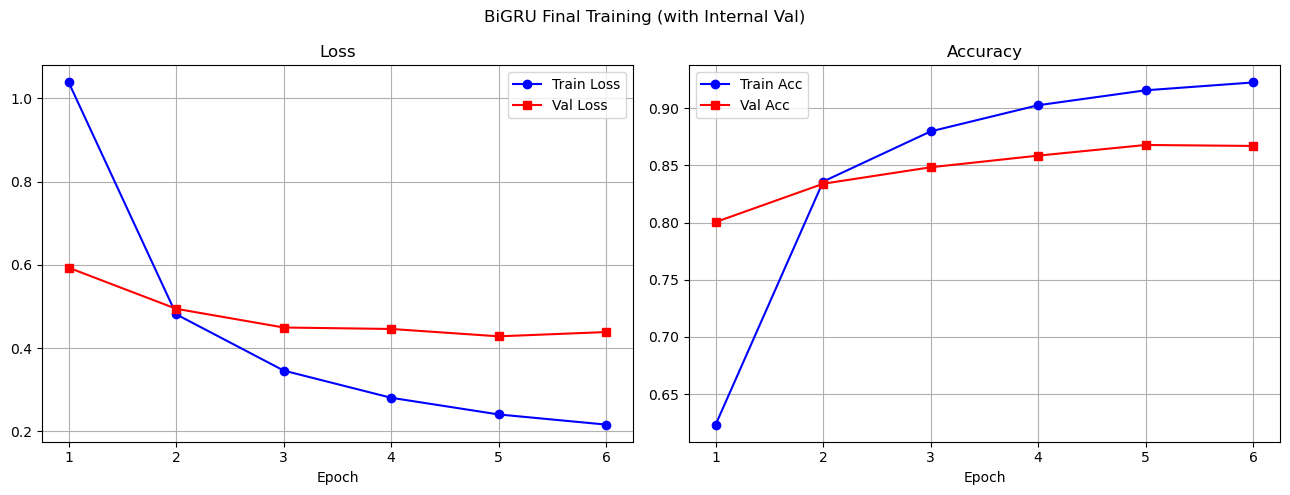

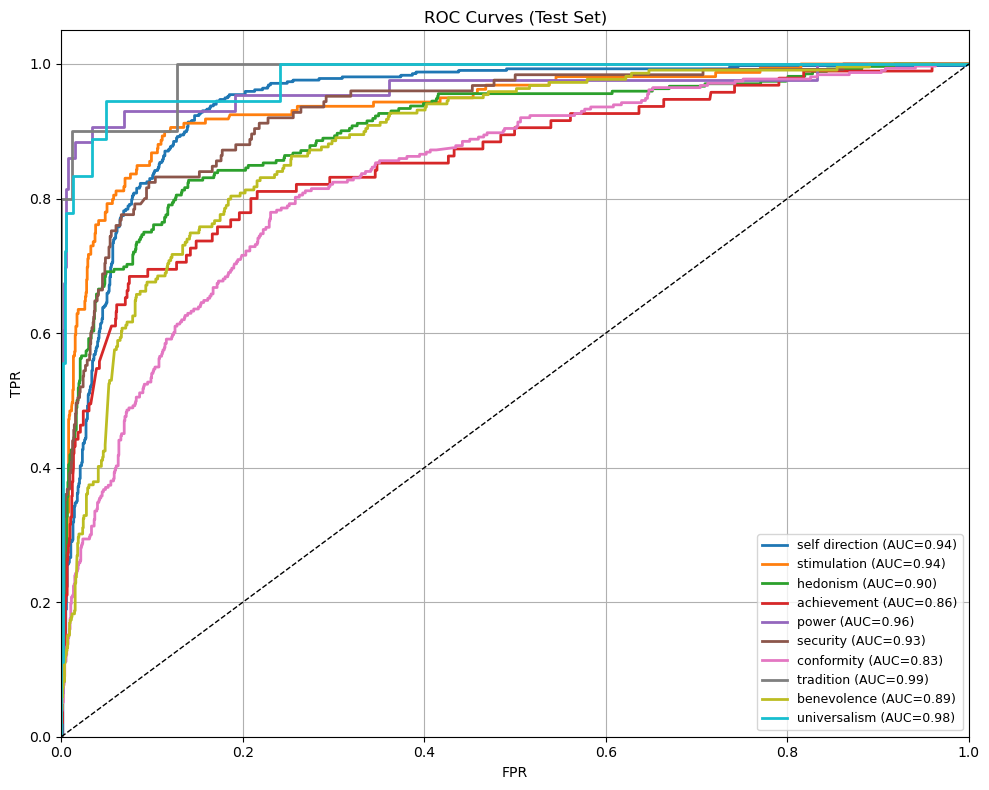

In [2]:
# ==============================
# 0. IMPORTS & SETUP (FIXED: no warnings, correct imports)
# ==============================
import pandas as pd
import numpy as np
import re
import os
import torch
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# ✅ label_binarize is in preprocessing (modern sklearn)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, 
    precision_recall_fscore_support, confusion_matrix,
    roc_curve, auc
)
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Download NLTK (quiet)
for res in ['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords', 'omw-1.4']:
    nltk.download(res, quiet=True)

print("✅ Libraries loaded & seeds set.")

# ==============================
# 1. LOAD DATASET
# ==============================
try:
    df = pd.read_csv('newextendeddataset.csv', encoding='utf-8-sig')
except Exception as e:
    raise RuntimeError(f"Failed to load dataset: {e}")

print(f"✅ Dataset loaded: {len(df)} rows.")

# ==============================
# 2. PREPROCESSING (same as binary models)
# ==============================
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # ✅ Raw strings to avoid \[ warnings
    REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile(r'[^a-z #+_]')
    text = strip_html(text)
    text = remove_url(text)
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    return text

# Apply cleaning
df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)
df['Base_Reviews'].dropna(inplace=True)

# Tokenize & lemmatize (identical to binary)
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

preprocessed_texts = []
for text in df['Base_Reviews']:
    tokens = word_tokenize(text.lower())
    final_words = []
    for word, pos in pos_tag(tokens):
        if word not in stop_words and word.isalpha():
            lemma = lemmatizer.lemmatize(word, tag_map[pos[0]])
            final_words.append(lemma)
    preprocessed_texts.append(' '.join(final_words))

df['text_final'] = preprocessed_texts

# Map labels (10 human values)
y_dict = {
    'self direction': 0, 'stimulation': 1, 'hedonism': 2, 'achievement': 3, 'power': 4,
    'security': 5, 'conformity': 6, 'tradition': 7, 'benevolence': 8, 'universalism': 9
}
df['category'] = df['category'].str.strip().str.lower().map(y_dict)
df = df.dropna(subset=['text_final', 'category'])
df['category'] = df['category'].astype(int)

X_all = df['text_final'].values
y_all = df['category'].values
n_classes = 10

print(f"✅ Preprocessing done. Samples: {len(X_all)} | Classes: {np.bincount(y_all)}")

# === Device Setup ===
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU for TF
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Force TensorFlow to use CPU (critical for stability with PyTorch MPS)
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("✅ TensorFlow will use CPU only")

# ==============================
# 3. SPLIT: 85% Train / 15% Test (Stratified) ← TEST FROZEN!
# ==============================
X_train_raw, X_test_raw, y_train_raw, y_test_int = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42, stratify=y_all
)

print(f"\n📊 Final Splits:")
print(f"→ Train (85%): {len(X_train_raw)} | Test (15%): {len(X_test_raw)}")
print(f"→ Train classes: {np.bincount(y_train_raw)}")
print(f"→ Test classes:  {np.bincount(y_test_int)}")

# ==============================
# 4. GRID SEARCH + 3-FOLD CV ON TRAIN (85%) → Select Best HPs
# ==============================
print(f"\n🔍 Grid Search + 3-Fold CV on TRAIN (85%)...")

# Hyperparameter grid (reduced for speed; expand if needed)
LR_LIST = [1e-3, 1e-4]
BATCH_LIST = [32, 64]
EPOCHS_LIST = [6, 10]
DROPOUT_LIST = [0.2, 0.5]
GRU_UNITS_LIST = [32, 64]

maxlen = 100
grid_results = []

# 3-Fold CV for efficiency (5-fold is fine if resources allow)
skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for lr in LR_LIST:
    for bs in BATCH_LIST:
        for ep in EPOCHS_LIST:
            for do in DROPOUT_LIST:
                for gu in GRU_UNITS_LIST:
                    print(f"  → Trying: lr={lr}, bs={bs}, ep={ep}, do={do}, gru={gu}")
                    
                    cv_scores = []
                    for fold, (tr_idx, val_idx) in enumerate(skf_inner.split(X_train_raw, y_train_raw), 1):
                        # Split
                        X_tr_raw = X_train_raw[tr_idx]
                        X_v_raw = X_train_raw[val_idx]
                        y_tr_int = y_train_raw[tr_idx]
                        y_v_int = y_train_raw[val_idx]
                        
                        # ✅ Tokenizer FIT ONLY on fold-train
                        tokenizer = Tokenizer()
                        tokenizer.fit_on_texts(X_tr_raw)
                        vocab = len(tokenizer.word_index) + 1
                        
                        # Encode
                        X_tr_seq = tokenizer.texts_to_sequences(X_tr_raw)
                        X_v_seq = tokenizer.texts_to_sequences(X_v_raw)
                        X_tr_pad = pad_sequences(X_tr_seq, maxlen=maxlen, padding='post')
                        X_v_pad = pad_sequences(X_v_seq, maxlen=maxlen, padding='post')
                        
                        # ✅ Oversample ONLY fold-train
                        ros = RandomOverSampler(random_state=42)
                        X_tr_res, y_tr_res_int = ros.fit_resample(X_tr_pad, y_tr_int)
                        y_tr_res = to_categorical(y_tr_res_int, num_classes=n_classes)
                        y_v_cat = to_categorical(y_v_int, num_classes=n_classes)
                        
                        # Build model with current HPs
                        model = Sequential([
                            Embedding(vocab, 100, input_length=maxlen),
                            Bidirectional(GRU(gu, return_sequences=True)),
                            Dropout(do),
                            Bidirectional(GRU(gu)),
                            Dropout(do),
                            Dense(n_classes, activation='softmax')
                        ])
                        model.compile(
                            optimizer=Adam(learning_rate=lr),
                            loss='categorical_crossentropy',
                            metrics=['accuracy']
                        )
                        
                        # Train (fixed epochs for fairness)
                        model.fit(
                            X_tr_res, y_tr_res,
                            epochs=ep,
                            batch_size=bs,
                            verbose=0
                        )
                        
                        # Evaluate on *original* fold-val
                        _, val_acc = model.evaluate(X_v_pad, y_v_cat, verbose=0)
                        cv_scores.append(val_acc)
                    
                    mean_cv = np.mean(cv_scores)
                    std_cv = np.std(cv_scores)
                    print(f"    → CV Acc: {mean_cv:.4f} ± {std_cv:.4f}")
                    
                    grid_results.append({
                        'lr': lr, 'batch_size': bs, 'epochs': ep,
                        'dropout': do, 'gru_units': gu,
                        'cv_mean_acc': mean_cv, 'cv_std_acc': std_cv
                    })

# Select best by mean CV accuracy
grid_df = pd.DataFrame(grid_results).sort_values('cv_mean_acc', ascending=False)
best = grid_df.iloc[0]
print(f"\n✅ Best HPs by 3-Fold CV Acc ({best['cv_mean_acc']:.4f} ± {best['cv_std_acc']:.4f}):")
print({k: v for k, v in best.items() if k not in ['cv_mean_acc', 'cv_std_acc']})

# ==============================
# 5. 5-FOLD CV ON TRAIN (85%) WITH BEST HPs (Final Performance Estimate)
# ==============================
print(f"\n🚀 5-Fold CV on TRAIN (85%) with best HPs...")

skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for fold, (tr_idx, val_idx) in enumerate(skf_outer.split(X_train_raw, y_train_raw), 1):
    print(f"\n--- Fold {fold}/5 ---")
    
    X_tr_raw = X_train_raw[tr_idx]
    X_v_raw = X_train_raw[val_idx]
    y_tr_int = y_train_raw[tr_idx]
    y_v_int = y_train_raw[val_idx]
    
    # ✅ Tokenizer FIT ONLY on fold-train
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_tr_raw)
    vocab = len(tokenizer.word_index) + 1
    
    # Encode
    X_tr_seq = tokenizer.texts_to_sequences(X_tr_raw)
    X_v_seq = tokenizer.texts_to_sequences(X_v_raw)
    X_tr_pad = pad_sequences(X_tr_seq, maxlen=maxlen, padding='post')
    X_v_pad = pad_sequences(X_v_seq, maxlen=maxlen, padding='post')
    
    # ✅ Oversample ONLY fold-train
    ros = RandomOverSampler(random_state=42)
    X_tr_res, y_tr_res_int = ros.fit_resample(X_tr_pad, y_tr_int)
    y_tr_res = to_categorical(y_tr_res_int, num_classes=n_classes)
    y_v_cat = to_categorical(y_v_int, num_classes=n_classes)
    
    # Build model with BEST HPs
    model = Sequential([
        Embedding(vocab, 100, input_length=maxlen),
        Bidirectional(GRU(int(best['gru_units']), return_sequences=True)),
        Dropout(float(best['dropout'])),
        Bidirectional(GRU(int(best['gru_units']))),
        Dropout(float(best['dropout'])),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=float(best['lr'])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train
    model.fit(
        X_tr_res, y_tr_res,
        epochs=int(best['epochs']),
        batch_size=int(best['batch_size']),
        verbose=0
    )
    
    # Evaluate on fold-val
    _, val_acc = model.evaluate(X_v_pad, y_v_cat, verbose=0)
    print(f"  → Fold {fold} Val Acc: {val_acc:.4f}")
    
    cv_results.append({'fold': fold, 'val_acc': val_acc})

# Summarize CV
cv_df = pd.DataFrame(cv_results)
mean_cv = cv_df['val_acc'].mean()
std_cv = cv_df['val_acc'].std()
print(f"\n📊 5-Fold CV on TRAIN (85%): {mean_cv:.4f} ± {std_cv:.4f}")

# ==============================
# 6. FINAL MODEL: Retrain on FULL TRAIN (85%) → Test on HELD-OUT (15%)
# ==============================
print(f"\n🎯 Retraining final BiGRU on FULL TRAIN (85%)...")

# Tokenizer fit on full train
final_tokenizer = Tokenizer()
final_tokenizer.fit_on_texts(X_train_raw)
vocab_final = len(final_tokenizer.word_index) + 1

# Encode
X_train_seq = final_tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = final_tokenizer.texts_to_sequences(X_test_raw)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# ✅ Oversample FULL TRAIN only
ros_final = RandomOverSampler(random_state=42)
X_train_res, y_train_res_int = ros_final.fit_resample(X_train_pad, y_train_raw)
y_train_res = to_categorical(y_train_res_int, num_classes=n_classes)
y_test_cat = to_categorical(y_test_int, num_classes=n_classes)

# Final model
final_model = Sequential([
    Embedding(vocab_final, 100, input_length=maxlen),
    Bidirectional(GRU(int(best['gru_units']), return_sequences=True)),
    Dropout(float(best['dropout'])),
    Bidirectional(GRU(int(best['gru_units']))),
    Dropout(float(best['dropout'])),
    Dense(n_classes, activation='softmax')
])
final_model.compile(
    optimizer=Adam(learning_rate=float(best['lr'])),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Use small internal val (10% of train) for early stopping
X_tr, X_val_int, y_tr, y_val_int = train_test_split(
    X_train_res, y_train_res, test_size=0.1, random_state=42,
    stratify=y_train_res_int
)

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = final_model.fit(
    X_tr, y_tr,
    validation_data=(X_val_int, y_val_int),
    epochs=int(best['epochs']),
    batch_size=int(best['batch_size']),
    callbacks=[es],
    verbose=1
)

# Save
final_model.save('./final_bigru_10class_cv.h5')
with open('./final_bigru_tokenizer_cv.pkl', 'wb') as f:
    pickle.dump(final_tokenizer, f)
print("✅ Final model & tokenizer saved.")

# ==============================
# 7. FINAL EVALUATION ON TEST SET (15%)
# ==============================
idx_to_class = {v: k for k, v in y_dict.items()}
class_names = [idx_to_class[i] for i in range(n_classes)]

test_loss, test_acc = final_model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\n🟩 FINAL TEST ACCURACY (Held-Out, Natural Distribution): {test_acc:.4f}")

y_pred_proba = final_model.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\n=== FINAL CLASSIFICATION REPORT (TEST SET) ===")
print(classification_report(y_test_int, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('BiGRU (10-Class) Confusion Matrix — Final Test')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig('BiGRU_10class_ConfusionMatrix_Test.png', dpi=300, bbox_inches='tight')
plt.show()

# Learning Curves
plt.figure(figsize=(13, 5))
epochs = range(1, len(history.history['loss']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'b-o', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Val Loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'b-o', label='Train Acc')
plt.plot(epochs, history.history['val_accuracy'], 'r-s', label='Val Acc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)

plt.suptitle('BiGRU Final Training (with Internal Val)')
plt.tight_layout()
plt.savefig('BiGRU_10class_LearningCurves.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test_int, classes=list(range(n_classes)))
plt.figure(figsize=(10, 8))
colors = itertools.cycle(plt.cm.tab10.colors)
for i, color in zip(range(n_classes), colors):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_i = auc(fpr_i, tpr_i)
    plt.plot(fpr_i, tpr_i, color=color, lw=2, label=f'{class_names[i]} (AUC={auc_i:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves (Test Set)')
plt.legend(fontsize=9, loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('BiGRU_10class_ROC_Test.png', dpi=300, bbox_inches='tight')
plt.show()